In [1]:
# ## Please follow the instructions from https://github.com/matplotlib/ipympl. In case of running into troubles follow https://candid.technology/error-displaying-widget-model-not-found/ or change matplotlib widget to matplotlib inline
%matplotlib widget

# H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001)

We illustrate a simple workflow with the driven and damped qubit example studied in - H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001).

In [2]:
## 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import numpy as np
from numba import jit

## Library
import qt_unraveling as qtr

# ## Opitonal
# import qt_unraveling.usual_operators_ as op

In [3]:
## Opitonal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

In [4]:
## Parameters 
gamma = 1
omega = 10

## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## Initial state 
initialState = np.array([1,1], dtype = np.complex128) ## Pure state
# initialState = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C') ## Mixed state

## Lindblad operators
L = np.sqrt(gamma)*np.array([qtr.sigmam], dtype=np.complex128)

# Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
# ## Fixed unraveling
u_matrix = np.eye(np.shape(L)[0], dtype=np.complex128)
# h_matrix = 0.5*np.eye(np.shape(L)[0], dtype=np.complex128)

## Ortogonal freedom
# theta = 0
# oMatrix = np.array([[np.cos(theta), -np.sin(theta)],
#                   [np.sin(theta), np.cos(theta)]])

In [5]:
# You have the option to define an adaptive unraveling. This is done by defining it in term of a function of t and the state
# ## Adapative unraveling
@jit(nopython=True)
def u_matrix(t, rho):
    num_op = 1
    uM = np.zeros((num_op,num_op), dtype=np.complex128)
    uM[0,0] = -np.trace(np.dot(rho,qtr.sigmam))/np.trace(np.dot(rho,qtr.sigmap))
    return uM

In [6]:
## Time parameters
t0 = 0
tf = 10
time_steps = 30000
dt = int(abs(tf-t0)/time_steps)

## Time range
timelist = np.linspace(t0, tf, np.int32(time_steps))

## Basic functionalities

This library is based on two main unraveling schemes: quantum jump (QJump) and diffusive schemes. The following shows how you can use the basic functionalities of this library. You can start by using the System class, which gives support to every unraveling method on the library:

In [7]:
%%time
## System definition
qtr_test = qtr.System(H0, initialState, timelist, lindbladList = L, uMatrix = u_matrix)

CPU times: user 6.88 ms, sys: 995 µs, total: 7.87 ms
Wall time: 47.7 ms


/home/deo/anaconda3/lib/python3.9/site-packages/qt_unraveling/qt_unraveling.py:57: UserWarning: Initial state is unnormalized. Normalized state taken instead
  warnings.warn('Initial state is unnormalized. Normalized state taken instead')


### Unitary evolution

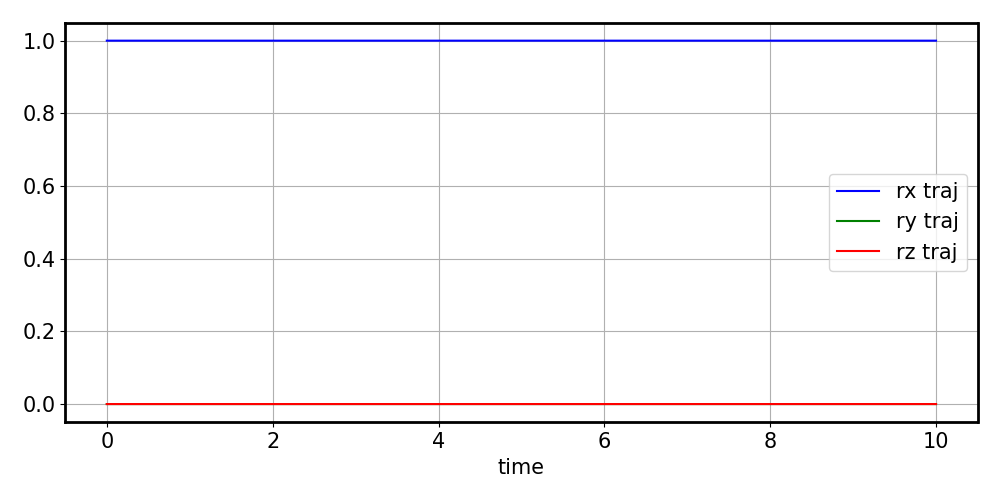

In [8]:
## Von Neumann evolution
unitary_evol = qtr_test.vonneumannAnalitical()

# Von Neumann plot
qtr.misc.rhoBlochcomp_plot(unitary_evol, qtr_test.timeList, label='traj')
plt.tight_layout()

### Diffusive trajectory

In [9]:
%%time
## Average conditional diffusive evoltuion
rho_diff = qtr_test.diffusiveRhoAverage(n_trajectories=1, method='milstein')

Compiling diffusiveRhoAverage ...
Compiling diffusiveRhoTrajectory ...
CPU times: user 29.5 s, sys: 180 ms, total: 29.7 s
Wall time: 32.6 s


In [10]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindbladAnalitical()

/home/deo/anaconda3/lib/python3.9/site-packages/qt_unraveling/qt_unraveling.py:351: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, C))
  return standartLindblad_operator(hamiltonian, lindblad_ops, rho_it, it)


CPU times: user 23.7 s, sys: 66.2 ms, total: 23.8 s
Wall time: 24 s


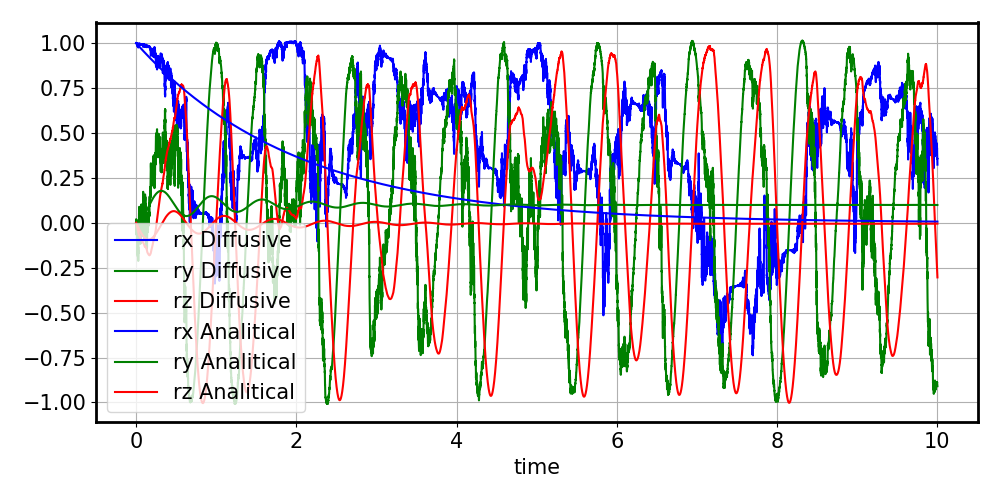

In [11]:
## Diffusive plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_diff, qtr_test.timeList, label='Diffusive', line='-', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()

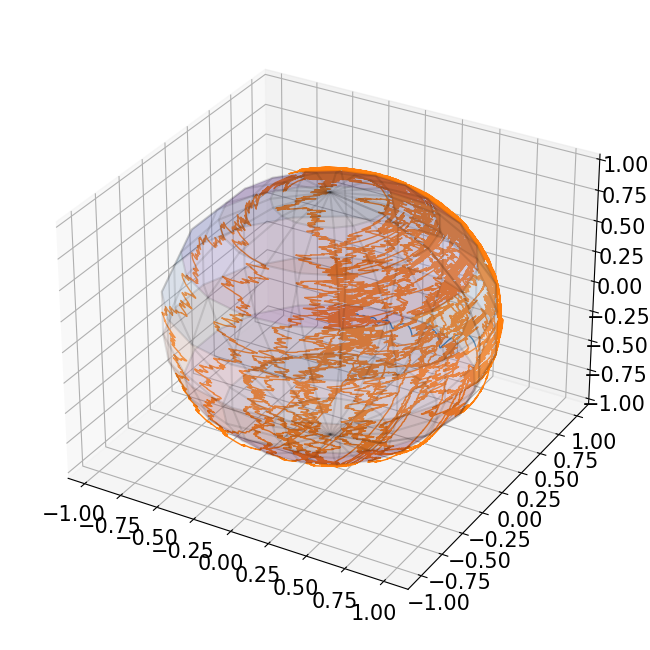

In [12]:
qtr.misc.rhoBlochSphere([lindblad_evol, rho_diff])

### Jump trajectory

In [13]:
%%time
## Average conditional Qjump evoltuion
coherent_fields = np.array([0.01,0.01], dtype=np.complex128)
rho_qjump = qtr_test.jumpRhoAverage(n_trajectories=1, coherent_fields=coherent_fields)

Compiling jumpRhoAverage ...
Compiling jumpRhoTrajectory ...
CPU times: user 10.4 s, sys: 164 ms, total: 10.6 s
Wall time: 12.3 s


In [14]:
%%time
# Anlitical unconditional diffusive evolution
lindblad_evol = qtr_test.lindbladAnalitical()

CPU times: user 9.69 s, sys: 32.7 ms, total: 9.72 s
Wall time: 9.85 s


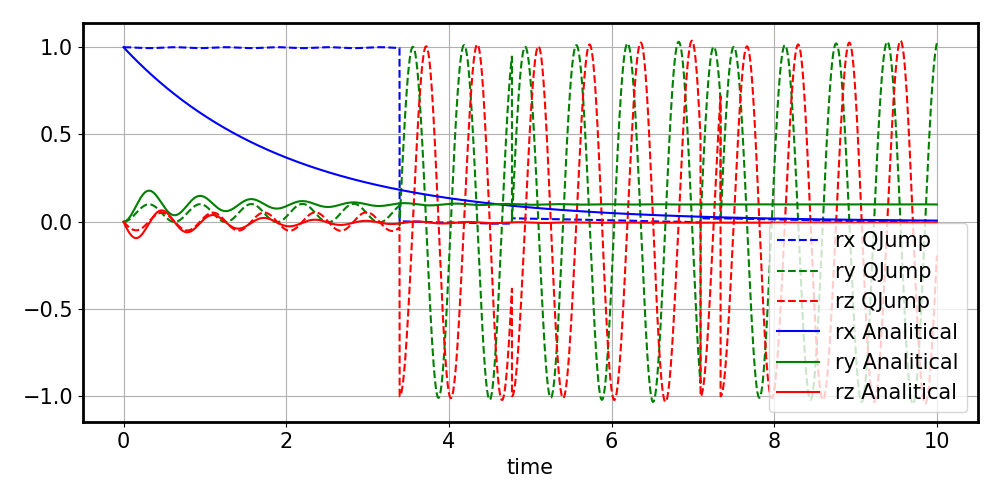

In [15]:
## Qjump plot
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(rho_qjump, qtr_test.timeList, label='QJump', line='--', ax=ax)
qtr.misc.rhoBlochcomp_plot(lindblad_evol, qtr_test.timeList, label='Analitical', line='-', ax=ax)
plt.tight_layout()

### Quantum jump connection to the diffusive unraveling

The Qjump methods are equiped with an unraveling option that allows us to explore the continous limit of the this scheme

In [16]:
%%time
## Large coherent field mu and small time step dt
coherent_fields = np.array([5,5], dtype=np.complex128)
qjump_coh_traj = qtr_test.jumpRhoTrajectory(coherent_fields=coherent_fields, seed=5)

CPU times: user 1.74 s, sys: 3.77 ms, total: 1.75 s
Wall time: 1.77 s


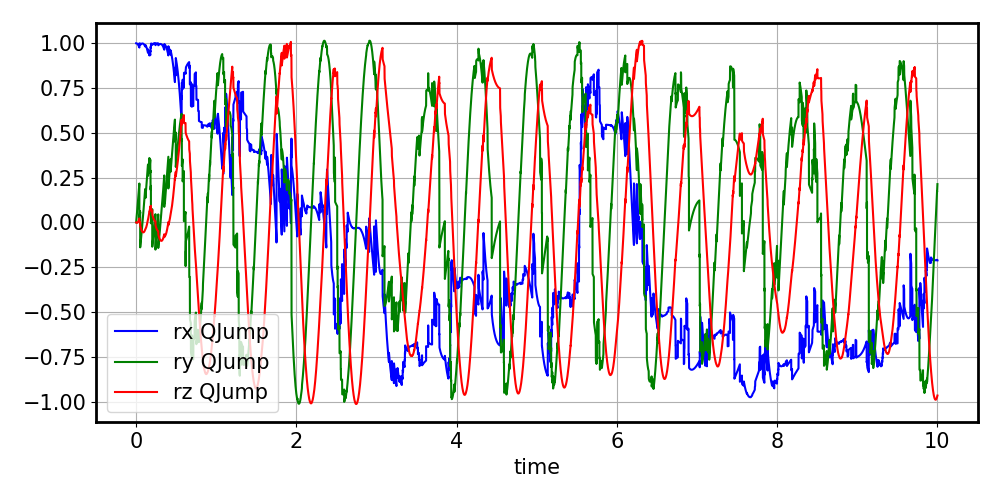

In [17]:
## Jump trajectory
qtr.misc.rhoBlochcomp_plot(qjump_coh_traj, qtr_test.timeList, label='QJump', line='-')
plt.tight_layout()

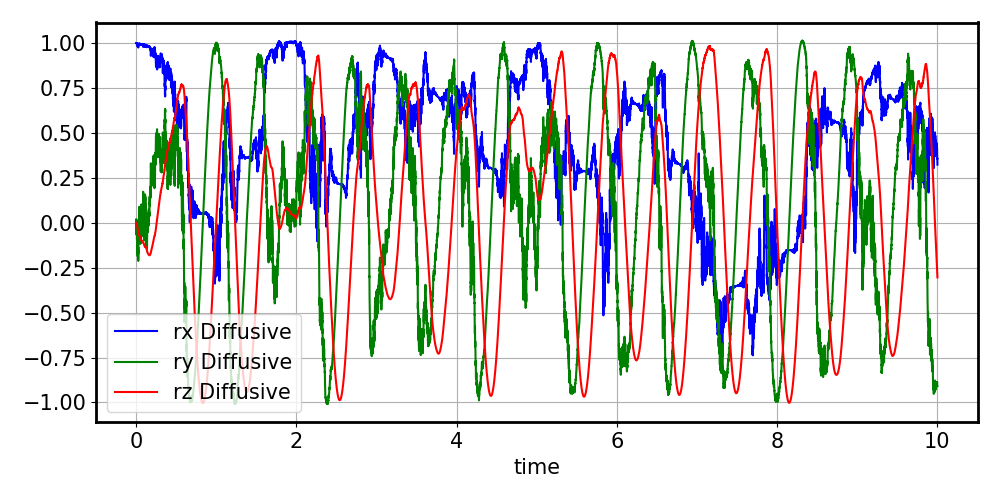

In [18]:
## Diffusive trajectory
rho_diffusive = qtr_test.diffusiveRhoTrajectory(method='milstein')

## Diffusive plot
qtr.misc.rhoBlochcomp_plot(rho_diffusive, qtr_test.timeList, label='Diffusive', line='-')
plt.tight_layout()

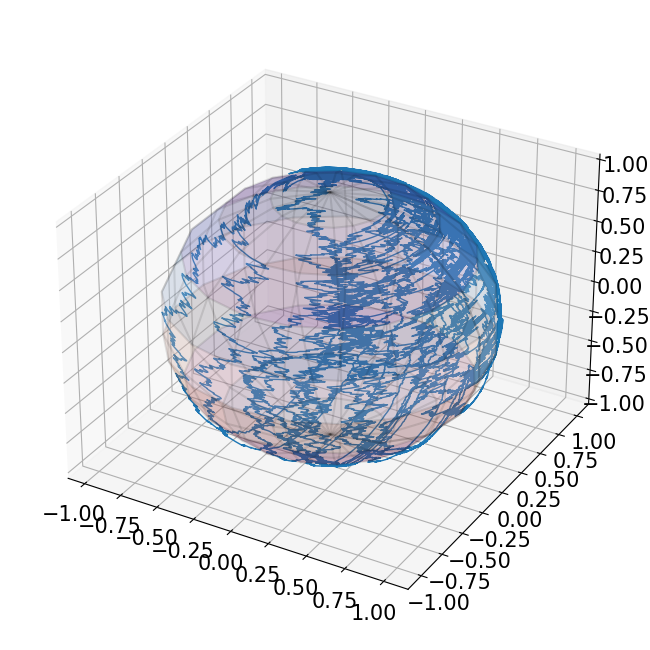

In [19]:
qtr.misc.rhoBlochSphere([rho_diffusive])

### Quantum Feedback processes

An application of the diffusive scheme is the possibility of feeding back the continuos currents via an extra term in the system Hamiltonian as described in [[1]](https://arxiv.org/abs/1102.3098). Each feedbcak operator corerspond to a Hermitian operator that describe the feedback action on the system. Our library is capable of implementing this processes as follows

In [20]:
## Parameters 
gamma = 1
omega = 10

## Hamiltonian
H0 = omega/2.0 * qtr.sigmax

## Time parameters
t0 = 0
tf = 10
time_steps = 30000

## Time range
timelist = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
initialState = np.array([1,1], dtype = np.complex128) ## Pure state
# initialState = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C') ## Mixed state

## Lindblad operators
L = np.sqrt(gamma)*np.array([qtr.sigmam], dtype=np.complex128)

# Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
## Fixed unraveling
u_matrix = -1*np.eye(np.shape(L)[0], dtype=np.complex128)

@jit(nopython=True)
def F_func(t):
    num_op = 2
    F_list = np.zeros((num_op,2,2), dtype=np.complex128)
    F_list[0] = np.sin(0.5*t)*qtr.sigmay
    F_list[1] = np.cos(t)*qtr.sigmaz
    # F_list[0] = qtr.sigmay
    # F_list[1] = qtr.sigmaz
    return F_list


In [21]:

%%time
## System definition
qtr_test = qtr.System(H0, initialState, timelist, lindbladList = L, FList = F_func, uMatrix=u_matrix)

CPU times: user 186 ms, sys: 2.94 ms, total: 189 ms
Wall time: 190 ms


/home/deo/anaconda3/lib/python3.9/site-packages/qt_unraveling/qt_unraveling.py:57: UserWarning: Initial state is unnormalized. Normalized state taken instead
  warnings.warn('Initial state is unnormalized. Normalized state taken instead')


In [22]:
%%time
feedback_traj = qtr_test.feedbackRhoTrajectory()

CPU times: user 8.44 s, sys: 60.5 ms, total: 8.5 s
Wall time: 8.31 s


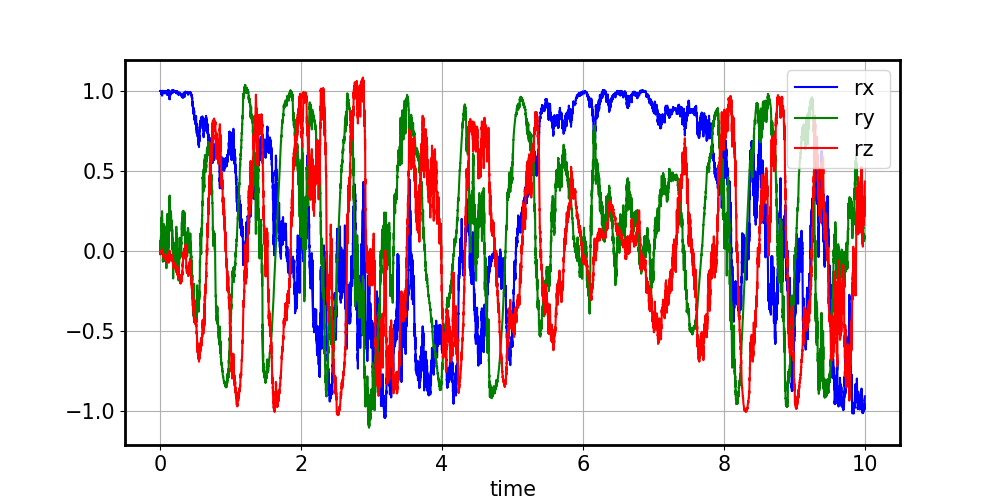

In [23]:
qtr.misc.rhoBlochcomp_plot(feedback_traj, timelist, line='-')

In [24]:
%%time
n_trajectories = 1000
average_feedback_traj = qtr_test.feedbackRhoAverage(n_trajectories)

CPU times: user 5.67 s, sys: 4.9 s, total: 10.6 s
Wall time: 3min 35s


In [25]:
feedback_evol = qtr_test.feedbackAnalitical()

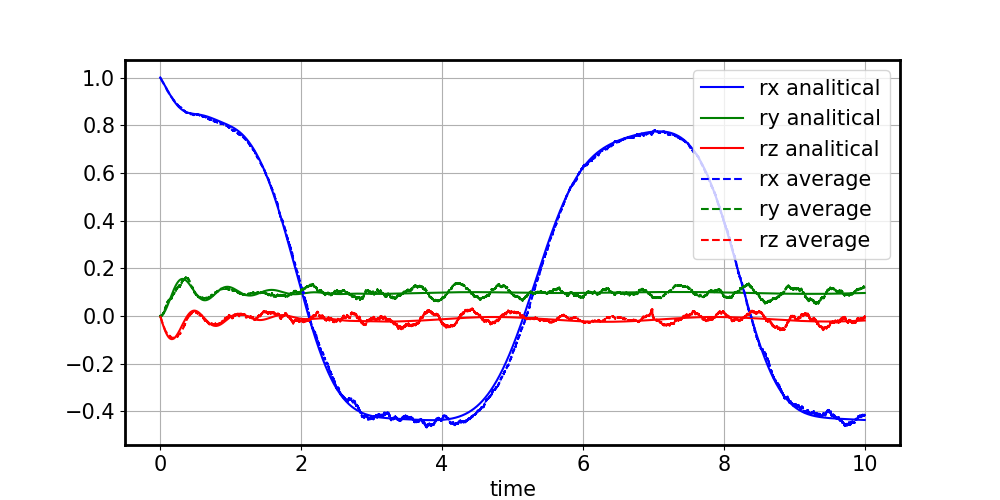

In [26]:
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(feedback_evol, timelist, label='analitical', ax=ax, line='-')
qtr.misc.rhoBlochcomp_plot(average_feedback_traj, timelist, label='average', ax=ax, line='--')

In [27]:
feedback_traj_delay = qtr_test.feedbackRhoTrajectory_delay(tau=0)

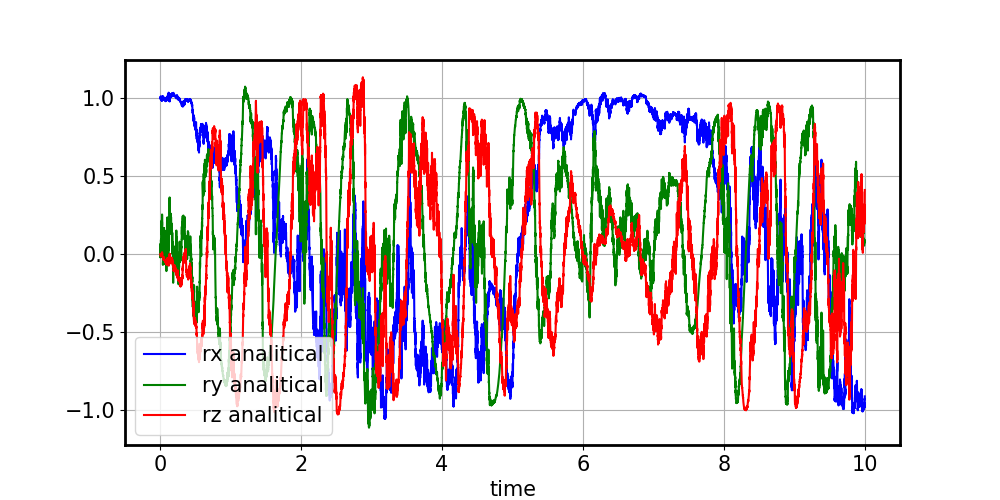

In [28]:
fig, ax = qtr.misc.figure()
qtr.misc.rhoBlochcomp_plot(feedback_traj_delay, timelist, label='analitical', ax=ax, line='-')

In [40]:
%%time
n_trajectories = 1000
average_feedback_traj_with_delay = qtr_test.feedbackRhoAverage_delay(n_trajectories, tau=1)

CPU times: user 5.21 s, sys: 4.67 s, total: 9.88 s
Wall time: 3min 34s


(-1.0, 1.0)

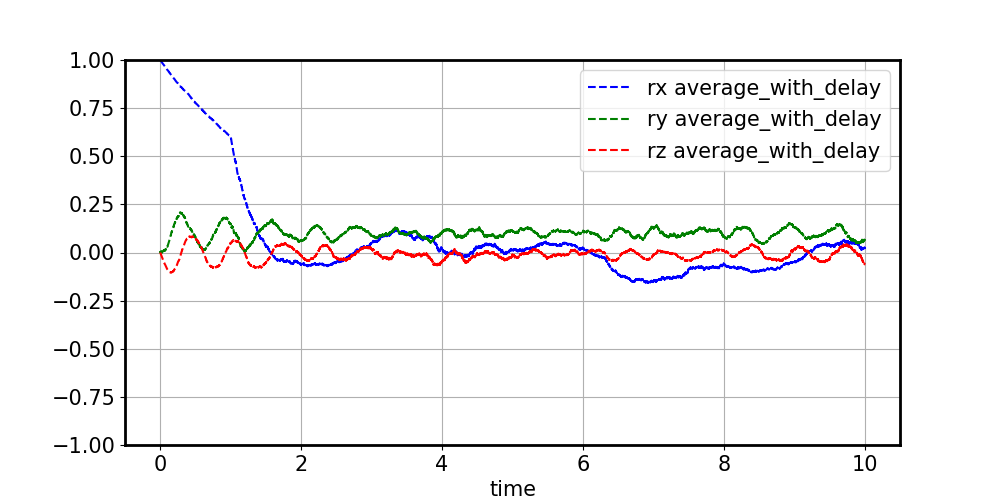

In [42]:
fig, ax = qtr.misc.figure()
# qtr.misc.rhoBlochcomp_plot(feedback_evol, timelist, label='analitical', ax=ax, line='-')
qtr.misc.rhoBlochcomp_plot(average_feedback_traj_with_delay, timelist, label='average_with_delay', ax=ax, line='--')
plt.ylim(-1,1)

# TEST

In [31]:
# from numba import njit, jit, complex128, float64, objmode
# from qt_unraveling.diffusive_trajectory import diffusiveRhoEulerStep_
# import qt_unraveling.usual_operators_ as op

In [32]:
# @njit
# def get_currens_measurement(stateRho, L_it):
#     expected_value_quadtature_op = np.zeros(np.shape(L_it)[0], dtype=np.complex128)
#     for n_L, L in enumerate(L_it):
#         expected_value_quadtature_op[n_L] += np.trace(np.dot(L + np.conjugate(np.transpose(L)), stateRho))
#     return expected_value_quadtature_op

# ## Implementing equation 
# @njit
# def feedbackRhoTrajectory_delay(initialStateRho, timelist, drivingH, original_lindbladList, lindbladList, Flist, tau, seed=0):
#     ## Timelist details
#     timeSteps = np.shape(timelist)[0]
#     dt = timelist[1] - timelist[0]
#     n_tau = int(tau/dt)

#     ## Hamiltonian shape
#     hamiltonian_dimension = np.shape(drivingH(0))
    
#     ## Number of Lindblad operators
#     number_lindblad_op = np.shape(lindbladList(timelist[0], initialStateRho))[0]

#     ## Stocastics increments
#     zeta = 0
#     with objmode(zeta='float64[:,:]'):
#         rng = np.random.default_rng(seed)
#         zeta = rng.normal(loc=0, scale=1, size=(number_lindblad_op, timeSteps))

#     feedback_hamiltonian = np.zeros(hamiltonian_dimension, dtype=np.complex128)
#     second_order_expansion_term = np.zeros(np.shape(initialStateRho), dtype=np.complex128)
#     missing_term_order_dt = np.zeros(np.shape(initialStateRho), dtype=np.complex128)
#     original_L_it = original_lindbladList

#     rho_trajectory = np.ascontiguousarray(np.zeros((timeSteps, np.shape(initialStateRho)[0], np.shape(initialStateRho)[0]), dtype=np.complex128))
#     rho_trajectory[0] += np.ascontiguousarray(initialStateRho)
#     for n_it, it in enumerate(timelist[:-1]):
#         ## Lindblad ops for time it
#         L_it = lindbladList(it, rho_trajectory[n_it])

#         ## reset terms
#         feedback_hamiltonian *= 0
#         second_order_expansion_term *= 0
#         missing_term_order_dt *= 0
#         if n_it >= n_tau:
#             F_it = Flist(it - tau, rho_trajectory[n_it - n_tau])
#             measurements = get_currens_measurement(rho_trajectory[n_it - n_tau], L_it)
#             for n_measure, measure in enumerate(measurements):
#                 ## feedback hamiltonian like term
#                 feedback_hamiltonian += (measure + zeta[n_measure, n_it - n_tau]/np.sqrt(dt))*F_it[n_measure]
#                 ## missing term construction - check description
#                 for m_measure, _measure in enumerate(measurements): 
#                     missing_term_order_dt += -1j*dt*zeta[n_measure, n_it - n_tau]*zeta[m_measure, n_it]*op.Com(F_it[n_measure], op.H(L_it[m_measure], rho_trajectory[n_it]))
#             ## K**2 term
#             second_order_expansion_term += op.D_vec(F_it, rho_trajectory[n_it])*dt

#         rho_trajectory[n_it+1] = rho_trajectory[n_it] + diffusiveRhoEulerStep_(rho_trajectory[n_it], drivingH(it) + feedback_hamiltonian, original_L_it, L_it, zeta[:, n_it], dt) + second_order_expansion_term + missing_term_order_dt

#     return rho_trajectory

In [33]:
# %%time
# # feedback_traj_delay = qtr_test.feedbackRhoTrajectory_delay(tau=0)
# feedback_traj_delay = feedbackRhoTrajectory_delay(qtr_test.initialStateRho, 
#                                                     qtr_test.timeList,
#                                                     qtr_test.H, 
#                                                     qtr_test.original_lindbladList, 
#                                                     qtr_test.cList, 
#                                                     qtr_test.FList, 
#                                                     tau=5)

In [34]:
# %%time
# ## Average conditional diffusive evoltuion
# rho_diff = qtr_test.diffusiveRhoAverage(n_trajectories=1, method='milstein')

In [35]:
# fig, ax = qtr.misc.figure()
# qtr.misc.rhoBlochcomp_plot(feedback_traj_delay, timelist, label='analitical', ax=ax, line='-')
# # plt.ylim(-1.1,1.1)

In [36]:
# qtr.misc.rhoBlochcomp_plot(feedback_traj, timelist, line='-')